In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN

In [4]:
seismic = pd.read_parquet("Sleipner_4D_Seismic_Small.parquet.gzip", engine = "pyarrow")

In [2]:
def diff_by_coordinates(data, const_axis, const_val, x_axis, y_axis, year1, year2):
    data = data.loc[data[const_axis] == const_val]
    
    diff_data = data.copy()
    diff_data['diff'] = diff_data[year2] - diff_data[year1]
    
    diff_data = diff_data.loc[:,[x_axis,y_axis,'diff']]
    return diff_data

In [10]:
def get_water_and_co2(diff_coord):
    
    diffs = diff_coord["diff"].values.reshape(-1,1)
    
    kmeans = KMeans(
        init="k-means++",
        n_clusters=4,
        n_init=100,
        max_iter=40000,
        random_state=42
    )

    labels = kmeans.fit_predict(diffs) 
    
    unique, counts = np.unique(labels, return_counts=True)
    dict_counts = dict(zip(unique, counts))
    sorted_counts = sorted(dict_counts.items(), key=lambda x:x[1], reverse=False)
    
    co2_water_label = [sorted_counts[0][0],sorted_counts[1][0]]
    
    diff_coord['labels'] = labels
    water_and_co2_first = diff_coord.loc[diff_coord['labels'] == co2_water_label[0]]
    water_and_co2_second = diff_coord.loc[diff_coord['labels'] == co2_water_label[1]]
    
    water_and_co2 = pd.concat([water_and_co2_first,water_and_co2_second],axis = 0)
    water_and_co2 = water_and_co2.drop(columns=['diff','labels'], errors = 'ignore')

    return water_and_co2

In [15]:
def get_co2(water_and_co2):
    kmeans = KMeans(
        init="k-means++",
        n_clusters=2,
        n_init=100,
        max_iter=40000,
        random_state=42
    )

    kmeans.fit(water_and_co2)
    labels = kmeans.predict(water_and_co2)
    
    water_and_co2['labels'] = labels
    
    cluster0 = water_and_co2.loc[water_and_co2['labels'] == 0]
    cluster1 = water_and_co2.loc[water_and_co2['labels'] == 1]

    avg_z_c0 = cluster0['z'].mean()
    avg_z_c1 = cluster1['z'].mean()
    
    # higher in terms of z-axis == most likely co2
    co2 = cluster1 if (avg_z_c1) > avg_z_c0 else cluster0
        
    return co2

In [17]:
def remove_noise(co2):
    db = DBSCAN(eps=5, min_samples=30).fit(co2)
    labels = db.labels_

    co2_clean = co2.copy()
    co2_clean['labels'] = labels
    co2_clean = co2_clean.loc[co2_clean['labels'] != -1]

    labels2 = list(filter(lambda x: (x != -1), labels))
    co2_clean = co2_clean.drop(columns=['labels'])
    return co2_clean

In [19]:
def apply_and_plot(diff_coord,co2_clean):
    final_df = diff_coord.copy()
    final_df = final_df.drop(columns=['diff','labels'])
    final_df['labels'] = np.where(final_df.index.isin(co2_clean.index), 1, 0)
    final_df.plot.scatter( x = "x", y = "z", c = 'labels' ,s = 0.5, cmap='gray', figsize=(3,5)).invert_yaxis()

In [21]:
def filter_co2(y_const, year1, year2):
    diff_coord = diff_by_coordinates(seismic,"y",y_const,"x","z",year1,year2)
    water_and_co2 = get_water_and_co2(diff_coord)
    co2 = get_co2(water_and_co2)
    co2_clean = remove_noise(co2)
    apply_and_plot(diff_coord, co2_clean)

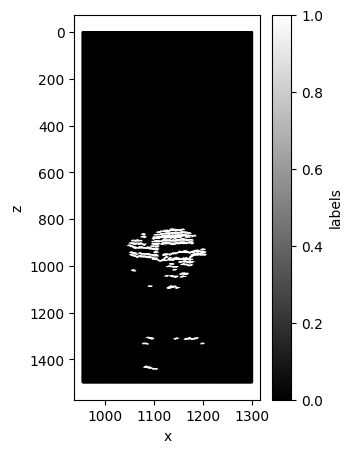

In [22]:
filter_co2(1840,"94","06")

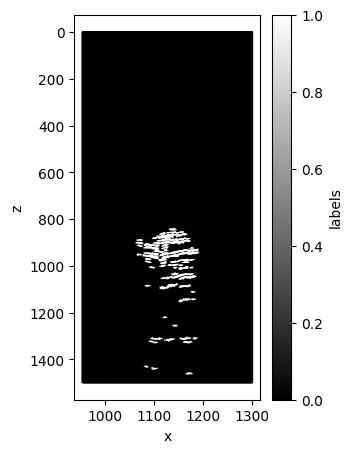

In [23]:
filter_co2(1840,"94","01")

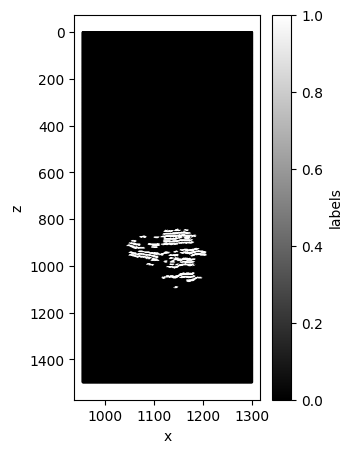

In [24]:
filter_co2(1840,"01","06")